In [ ]:
# ResNet-18


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import lr_scheduler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 30
learning_rate = 0.05

# Image preprocessing modules
transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor()])
transform_test = transforms.Compose([transforms.Resize(256),transforms.ToTensor()])


# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',train=True, transform=transform, download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',train=False,transform=transform_test)



transform = transforms.Compose([transforms.Resize(256), transforms.Grayscale(3),transforms.ToTensor()])
transform_test = transforms.Compose([transforms.Resize(256), transforms.Grayscale(3),transforms.ToTensor()])

#train_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=True, transform=transform,download=True)

#test_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=False, transform=transform_test)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=50, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)






def imshow(img):
    #img = img/2+0.5
    npimg = img.numpy()
    #print(np.shape(npimg))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()
print(np.shape(images[0]))
#plt.imshow(np.transpose(images[10].numpy()))
#plt.show()

imshow(torchvision.utils.make_grid(images))

model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=False).to(device)
model.fc = nn.Linear(512, 10).to(device)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr



# Train the model

val_acc_history = []
val_los_history = []

total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        if (i+1) % 1000 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images to a Torch Variable
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            val_acc_history.append(accuracy)
            val_los_history.append(loss.item())

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

    exp_lr_scheduler.step()



# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))


hist = [h.cpu().numpy() for h in val_acc_history]
hist = np.array(hist)
losshist = np.array(val_los_history)

epochs_y = np.array(len(hist))
#print(ihist)
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,len(hist)+1),hist)
#plt.legend()
plt.show()
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,len(hist)+1),losshist)
plt.show()


PATH = './resnet18.pth'
torch.save(model.state_dict(), PATH)

Sun May 16 11:26:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    41W / 250W |   7103MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

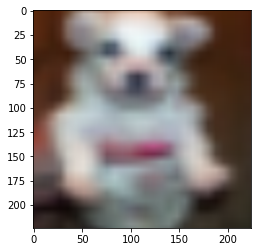

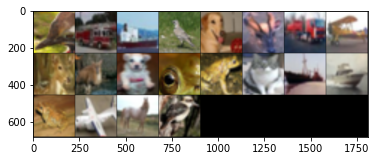

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch [1/30], Step [2500/2500] Loss: 1.8622
Iteration: <built-in function iter>. Loss: 1.8621718883514404. Accuracy: 32.90999984741211
Epoch [2/30], Step [2500/2500] Loss: 1.3755
Iteration: <built-in function iter>. Loss: 1.375457525253296. Accuracy: 52.779998779296875
Epoch [3/30], Step [2500/2500] Loss: 0.7903
Iteration: <built-in function iter>. Loss: 0.7903128862380981. Accuracy: 64.43999481201172
Epoch [4/30], Step [2500/2500] Loss: 0.9713
Iteration: <built-in function iter>. Loss: 0.9712678790092468. Accuracy: 71.0
Epoch [5/30], Step [2500/2500] Loss: 1.7161
Iteration: <built-in function iter>. Loss: 1.7161147594451904. Accuracy: 67.15999603271484
Epoch [6/30], Step [2500/2500] Loss: 0.5046
Iteration: <built-in function iter>. Loss: 0.5045949220657349. Accuracy: 77.7699966430664
Epoch [7/30], Step [2500/2500] Loss: 0.4643
Iteration: <built-in function iter>. Loss: 0.4642832279205322. Accuracy: 78.05999755859375
Epoch [8/30], Step [2500/2500] Loss: 0.5494
Iteration: <built-in func

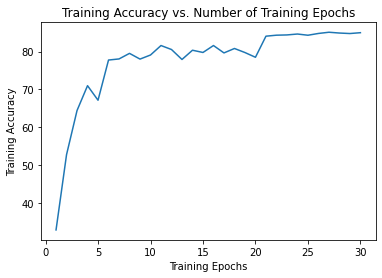

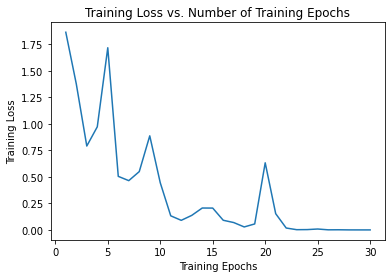

In [2]:
# VGG-19


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import lr_scheduler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 30
learning_rate = 0.05

# Image preprocessing modules
#transform = transforms.Compose([transforms.Pad(4),transforms.RandomHorizontalFlip(),#transforms.Resize(224),#transforms.RandomCrop(32),transforms.ToTensor()])

#transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor()])
#transform_test = transforms.Compose([transforms.Resize(256),transforms.ToTensor()])

# CIFAR-10 dataset
#train_dataset = torchvision.datasets.CIFAR10(root='../../data/',train=True, transform=transform,download=True)

#test_dataset = torchvision.datasets.CIFAR10(root='../../data/',train=False, transform=transform_test)

transform = transforms.Compose([transforms.Resize(256), transforms.Grayscale(3),transforms.ToTensor()])
transform_test = transforms.Compose([transforms.Resize(256), transforms.Grayscale(3),transforms.ToTensor()])

train_dataset_mnist = torchvision.datasets.MNIST(root='./data', 
                            train=True, 
                            transform=transform,
                            download=True)

test_dataset_mnist = torchvision.datasets.MNIST(root='./data', 
                           train=False, 
                           transform=transform_test)  


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_mnist,
                                           batch_size=20, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset_mnist,
                                          batch_size=20, 
                                          shuffle=False)



def imshow(img):
    #img = img/2+0.5
    npimg = img.numpy()
    #print(np.shape(npimg))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()
print(np.shape(images[0]))
plt.imshow(np.transpose(images[10].numpy(), (1,2,0)))
plt.show()

imshow(torchvision.utils.make_grid(images))

model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=False).to(device)
#model.fc = nn.Linear(512, 10).to(device)
model.classifier[6] = nn.Linear(4096,10).to(device)
#print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

val_acc_history = []
val_los_history = []

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2500 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images to a Torch Variable
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            val_acc_history.append(accuracy)
            val_los_history.append(loss.item())

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
    exp_lr_scheduler.step()

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))


hist = [h.cpu().numpy() for h in val_acc_history]
hist = np.array(hist)
losshist = np.array(val_los_history)

epochs_y = np.array(len(hist))
#print(ihist)
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,len(hist)+1),hist)
plt.show()
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,len(hist)+1),losshist)
plt.show()
PATH = './vgg19.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
# GoogLeNet (inception v1)


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import lr_scheduler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 30
learning_rate = 0.05

# Image preprocessing modules
#transform = transforms.Compose([transforms.Pad(4),transforms.RandomHorizontalFlip(),transforms.Resize(299),transforms.RandomCrop(299),transforms.ToTensor()])

#transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor()])
#transform_test = transforms.Compose([transforms.Resize(256),transforms.ToTensor()])

# CIFAR-10 dataset
#train_dataset = torchvision.datasets.CIFAR10(root='../../data/',train=True, transform=transform,download=True)

#test_dataset = torchvision.datasets.CIFAR10(root='../../data/',train=False, transform=transform_test)


transform = transforms.Compose([transforms.Resize(256), transforms.Grayscale(3),transforms.ToTensor()])
transform_test = transforms.Compose([transforms.Resize(256), transforms.Grayscale(3),transforms.ToTensor()])

train_dataset_mnist = torchvision.datasets.MNIST(root='./data', 
                            train=True, 
                            transform=transform,
                            download=True)

test_dataset_mnist = torchvision.datasets.MNIST(root='./data', 
                           train=False, 
                           transform=transform_test)                                            

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_mnist,
                                           batch_size=20, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset_mnist,
                                          batch_size=20, 
                                          shuffle=False)



def imshow(img):
    #img = img/2+0.5
    npimg = img.numpy()
    #print(np.shape(npimg))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()
print(np.shape(images[0]))
plt.imshow(np.transpose(images[10].numpy(), (1,2,0)))
plt.show()

imshow(torchvision.utils.make_grid(images))

model = torch.hub.load('pytorch/vision:v0.9.0', 'googlenet', pretrained=False).to(device)
model.aux_logits=False
#model.fc = nn.Linear(512, 10).to(device)
#model.AuxLogits.fc = nn.Linear(768, 10).to(device)
model.aux1.fc2 = nn.Linear(1024, 10).to(device)
model.aux2.fc2 = nn.Linear(1024, 10).to(device)
model.fc = nn.Linear(model.fc.in_features, 10).to(device)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

val_acc_history = []
val_los_history = []

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2500 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images to a Torch Variable
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            val_acc_history.append(accuracy)
            val_los_history.append(loss.item())

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))


hist = [h.cpu().numpy() for h in val_acc_history]
hist = np.array(hist)
losshist = np.array(val_los_history)

epochs_y = np.array(len(hist))

plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,len(hist)+1),hist)

plt.show()
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,len(hist)+1),losshist)
plt.show()

PATH = './googlenet.pth'
torch.save(model.state_dict(), PATH)